<a href="https://colab.research.google.com/github/pchernic/Bank-Fraud-Detection-with-PySpark/blob/main/%5BPyspark%5D_Brazilian_Bank_Fraud_Transactions_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pyspark Installation

In [1]:
# Instalar a última versão do PySpark
!pip install pyspark #==3.3.1

# Instalar o NGROK
!wget -qnc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -n -q ngrok-stable-linux-amd64.zip

# Autenticar a sessão do SparkUI com NGROK
!./ngrok authtoken 2KBeQEmmd1YNlQ86GGKf3KFOkb3_6sQH7JEnvEhDxwn9A7WnT
get_ipython().system_raw('./ngrok http 4050 &')
!sleep 10
!curl -s http://localhost:4040/api/tunnels | grep -Po 'public_url":"(?=https)\K[^"]*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=5b199cc3fe2388ddc03c9a4007eb5d71c2103e52f4c7547c114ee4fe7674e59e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
https://feaa-34-91-229-4.ngrok-free.app


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Business Understanding


**1. Project Overview:**

The Fraud Detection in Financial Transactions project aims to develop and deploy a machine learning model that can effectively detect fraudulent transactions within a financial dataset. By leveraging advanced analytics and machine learning techniques, this project seeks to enhance security measures and minimize financial losses due to fraudulent activities.

**2. Business Problem:**

Financial institutions face the constant challenge of identifying and preventing fraudulent transactions. Fraudulent activities can result in substantial financial losses, damage to reputation, and customer trust erosion. Detecting fraudulent transactions in real-time is critical for mitigating these risks.

**3. Project Objectives:**

- Develop a predictive model to identify fraudulent transactions.
- Enhance the accuracy and efficiency of fraud detection.
- Reduce financial losses and improve customer confidence.
- Automate the detection process for real-time monitoring.
- Provide actionable insights for fraud investigation and prevention.

**4. Dataset Description:**

The project utilizes a comprehensive financial transaction dataset containing various attributes such as transaction amount, transaction date, recipient details, transaction category, and more. The dataset includes both legitimate and fraudulent transactions.

The dataset used in this project contains financial transactions processed through Brazil's PIX system. PIX, or "Pagamentos Instantâneos," **is a real-time payment system introduced by Brazil's Central Bank.** Key features include:

- **Instant Payments:** PIX allows instant money transfers 24/7, offering quick and convenient transactions.

- **User Identification:** Transactions are linked to user identifiers like phone numbers or email addresses, enhancing security.

- **Wide Adoption:** PIX is widely adopted for various transactions, attracting millions of users.

- **Transaction Types:** The dataset covers diverse transaction types, including P2P transfers, payments, and bill payments.

- **Fraud Challenge:** Due to its popularity, PIX faces fraud risks. The project aims to develop a fraud detection model for PIX transactions.

This dataset contains legitimate and potentially fraudulent transactions, with the **goal of distinguishing between them effectively to enhance PIX system security.**

**5. Methodology:**

The project employs machine learning techniques, specifically logistic regression and random forest classification, to identify potentially fraudulent transactions. Key steps include data preprocessing, feature engineering, model training, and evaluation.

**6. Expected Outputs:**

- A trained machine learning model capable of predicting fraudulent transactions.
- Real-time integration of the model into the transaction processing system.
- Performance metrics, including precision, recall, F1-score, and ROC AUC, to assess model effectiveness.

**7. Business Impact:**

Implementing an effective fraud detection system is essential for the financial institution:

- **Financial Savings:** Reducing financial losses by detecting and preventing fraudulent transactions.
- **Customer Trust:** Enhancing customer trust and loyalty through proactive fraud prevention.
- **Operational Efficiency:** Automating the fraud detection process for faster response.
- **Regulatory Compliance:** Meeting regulatory requirements for fraud prevention.

**8. Future Directions:**

- Continuous model improvement through monitoring and feedback.
- Exploration of advanced machine learning algorithms and anomaly detection techniques.
- Integration of external data sources for enriched analysis.

**9. Stakeholders:**

- Financial institution leadership.
- Risk management teams.
- Data scientists and analysts.
- IT and security teams.

**10. Conclusion:**

The Fraud Detection in Financial Transactions project addresses the critical need for advanced fraud prevention in the financial sector. By deploying a robust machine learning model and continuously enhancing its capabilities, the project aims to protect the institution's financial interests, maintain customer trust, and ensure compliance with regulatory standards.

---

# Data Preparation

In [22]:
# Creating a SparkSession:

from pyspark.sql import SparkSession


spark = (
    SparkSession.builder
    .config('spark.ui.port', '4050')
    .appName('PixCase')
    .getOrCreate()
)

In [23]:
from pyspark.sql.types import *

json_path = '/content/drive/MyDrive/case_final.json'



### Setting Schema:

In [34]:
# Setting Schema

schema_remetente_destinatario = StructType([
    StructField('nome', StringType()),
    StructField('banco', StringType()),
    StructField('tipo', StringType())
])


schema_base_pix = StructType([
    StructField('id_transacao', IntegerType()),
    StructField('valor', DoubleType()),
    StructField('remetente', schema_remetente_destinatario),
    StructField('destinatario', schema_remetente_destinatario),
    StructField('chave_pix', StringType()),
    StructField('categoria', StringType()),
    StructField('transaction_date', StringType()),
    StructField('fraude', IntegerType())
])


# 2022-10-20 10:57:36

df = spark.read.json(
    json_path,
    schema=schema_base_pix,
    timestampFormat="yyyy-MM-dd HH:mm:ss",
)

In [35]:
#checking schema
df.printSchema()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- remetente: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- destinatario: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- fraude: integer (nullable = true)



In [36]:
#Checking df
df.show()

+------------+------------------+--------------------+--------------------+---------+-------------+-------------------+------+
|id_transacao|             valor|           remetente|        destinatario|chave_pix|    categoria|   transaction_date|fraude|
+------------+------------------+--------------------+--------------------+---------+-------------+-------------------+------+
|        1000|            588.08|{Jonathan Gonsalv...|{Calebe Melo, Cai...|aleatoria|       outros|2021-07-16 05:00:55|     0|
|        1001|           80682.5|{Jonathan Gonsalv...|{Davi Lucas Perei...|  celular|transferencia|2022-04-20 12:34:01|     1|
|        1002|             549.9|{Jonathan Gonsalv...|{Sabrina Castro, ...|      cpf|        lazer|2022-07-10 16:51:34|     0|
|        1003|             90.83|{Jonathan Gonsalv...|{Francisco da Con...|aleatoria|   transporte|2022-10-20 10:57:36|     0|
|        1004|13272.619999999999|{Jonathan Gonsalv...|{Isabelly Ferreir...|    email|transferencia|2021-04-06 2

In [37]:
from pyspark.sql.functions import col

df_flatten = df.withColumns({
    'remetente_nome':  col('remetente').getField('nome'),
    'remetente_banco':  col('remetente').getField('banco'),
    'remetente_tipo':  col('remetente').getField('tipo'),
    'destinatario_nome':  col('destinatario').getField('nome'),
    'destinatario_banco':  col('destinatario').getField('banco'),
    'destinatario_tipo':  col('destinatario').getField('tipo'),
}).drop('remetente', 'destinatario')


Here's a breakdown of what the code is doing:

1. Importing the `col` function from `pyspark.sql.functions`:

   ```python
   from pyspark.sql.functions import col
   ```

   This line imports the `col` function, which is used to reference DataFrame columns.

2. Creating a new DataFrame (`df_flatten`):

   ```python
   df_flatten = df.withColumns({
       'remetente_nome':  col('remetente').getField('nome'),
       'remetente_banco':  col('remetente').getField('banco'),
       'remetente_tipo':  col('remetente').getField('tipo'),
       'destinatario_nome':  col('destinatario').getField('nome'),
       'destinatario_banco':  col('destinatario').getField('banco'),
       'destinatario_tipo':  col('destinatario').getField('tipo'),
   }).drop('remetente', 'destinatario')
   ```

   In this code block:

   - The `withColumns` method is used to create new columns in the DataFrame (`df`) by extracting specific fields from the nested 'remetente' and 'destinatario' structs.
   - The following columns are created in the new `df_flatten` DataFrame:
     - 'remetente_nome': Extracted from 'remetente' struct's 'nome' field.
     - 'remetente_banco': Extracted from 'remetente' struct's 'banco' field.
     - 'remetente_tipo': Extracted from 'remetente' struct's 'tipo' field.
     - 'destinatario_nome': Extracted from 'destinatario' struct's 'nome' field.
     - 'destinatario_banco': Extracted from 'destinatario' struct's 'banco' field.
     - 'destinatario_tipo': Extracted from 'destinatario' struct's 'tipo' field.

   - Finally, the `drop` method is used to remove the original 'remetente' and 'destinatario' columns from the DataFrame, leaving only the flattened columns.

This code effectively flattens the nested struct columns 'remetente' and 'destinatario' into individual columns in the `df_flatten` DataFrame, making it easier to work with the data in a flat format.

In [38]:
df_flatten.printSchema()

df_flatten.show()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- fraude: integer (nullable = true)
 |-- remetente_nome: string (nullable = true)
 |-- remetente_banco: string (nullable = true)
 |-- remetente_tipo: string (nullable = true)
 |-- destinatario_nome: string (nullable = true)
 |-- destinatario_banco: string (nullable = true)
 |-- destinatario_tipo: string (nullable = true)

+------------+------------------+---------+-------------+-------------------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+
|id_transacao|             valor|chave_pix|    categoria|   transaction_date|fraude|    remetente_nome|remetente_banco|remetente_tipo|   destinatario_nome|destinatario_banco|destinatario_tipo|
+------------+------------------+---------+-------------+-------------


# Data Understanding

### EDA

In [42]:
# Compute summary statistics for numerical columns
df_flatten.describe().show()


+-------+-----------------+------------------+---------+-----------+-------------------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|summary|     id_transacao|             valor|chave_pix|  categoria|   transaction_date|            fraude|    remetente_nome|remetente_banco|remetente_tipo|destinatario_nome|destinatario_banco|destinatario_tipo|
+-------+-----------------+------------------+---------+-----------+-------------------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|  count|           100000|            100000|   100000|     100000|             100000|            100000|            100000|         100000|        100000|           100000|            100000|           100000|
|   mean|          50999.5|10303.358732200059|     NULL|       NULL|               NULL|           0.15367|              NULL|           NULL|      

**What the summary reveals:**

- **Count**: The number of non-null values in each column.
- **Mean**: The mean (average) value for numerical columns.
- **Stddev**: The standard deviation for numerical columns, indicating the degree of data dispersion.
- **Min**: The minimum value in each column.
- **Max**: The maximum value in each column.

For example:
- The 'valor' column has a mean value of approximately **10,303.36 and a standard deviation of approximately 20,875. It ranges from a minimum value of 0.0 to a maximum value of 89,996.33.**
- The 'fraude' column has a **mean of 0.15367, indicating that about 15.37% of transactions are labeled as fraudulent (1), while the majority are not (0).**
- The 'transaction_date' column **ranges from January 14, 2021, to January 15, 2023.**

These summary statistics provide a basic understanding of the central tendency and dispersion of our numerical data, as well as the range of values in each column. It's a good starting point for further exploration and analysis of your dataset.



### Check for Missing Values.

In [40]:
from pyspark.sql.functions import col, sum

# Check for missing values in each column
missing_values = df_flatten.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_flatten.columns])
missing_values.show()


+------------+-----+---------+---------+----------------+------+--------------+---------------+--------------+-----------------+------------------+-----------------+
|id_transacao|valor|chave_pix|categoria|transaction_date|fraude|remetente_nome|remetente_banco|remetente_tipo|destinatario_nome|destinatario_banco|destinatario_tipo|
+------------+-----+---------+---------+----------------+------+--------------+---------------+--------------+-----------------+------------------+-----------------+
|           0|    0|        0|        0|               0|     0|             0|              0|             0|                0|                 0|                0|
+------------+-----+---------+---------+----------------+------+--------------+---------------+--------------+-----------------+------------------+-----------------+



It appears that there are no missing values (null values) in any of the columns of your DataFrame based on the count of null values provided in the summary statistics. This is a good sign for **data quality.**

### Data Visualization:

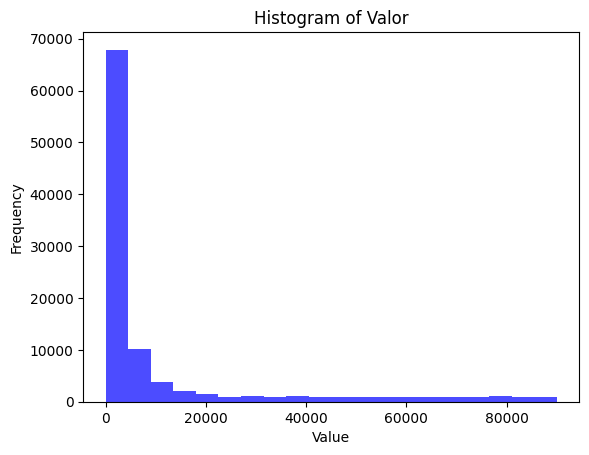

In [43]:
import matplotlib.pyplot as plt

# Convert the 'valor' column to a Pandas DataFrame for plotting
valor_data = df_flatten.select('valor').toPandas()

# Create a histogram
plt.hist(valor_data['valor'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Valor')
plt.show()


### valor BoxPlot

- Understanding ranges of values for transactions

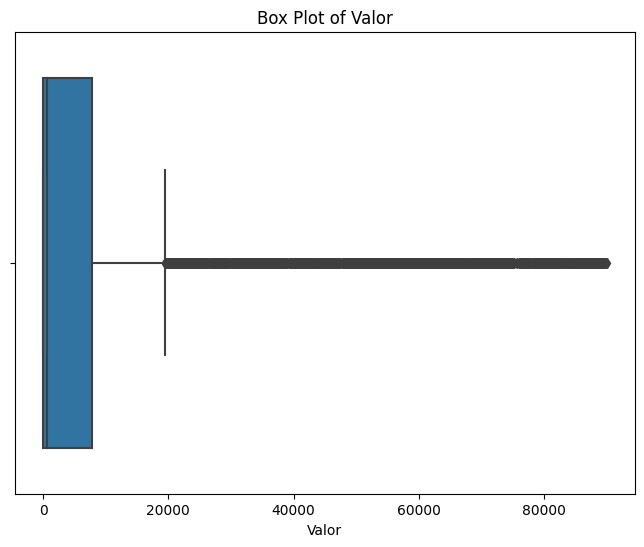

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot for the 'valor' column
plt.figure(figsize=(8, 6))
#to sample approximately 10% of the data for the box plot.
sns.boxplot(data=df_flatten.sample(fraction=0.1, seed=42).toPandas(), x='valor')
plt.title('Box Plot of Valor')
plt.xlabel('Valor')
plt.show()



### Barplot for numeric columns

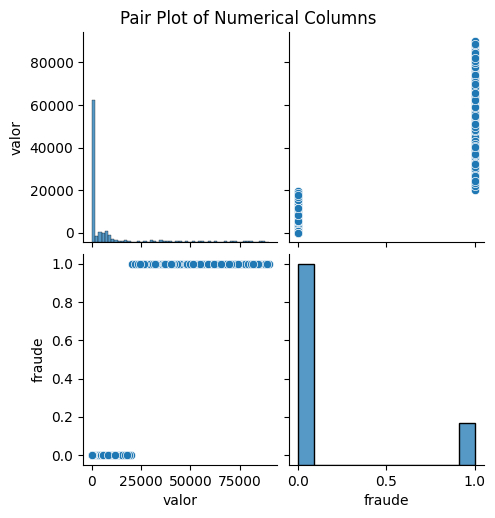

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a subset of numerical columns for the pair plot
numerical_cols = ['valor', 'fraude']

# Limit the DataFrame to a sample of 1000 rows
df_sample = df_flatten.limit(1000).select(*numerical_cols).toPandas()

# Create a pair plot for the selected numerical columns
sns.pairplot(df_sample)
plt.suptitle('Pair Plot of Numerical Columns', y=1.02)
plt.show()


### Correlation Heatmap (for numerical columns):

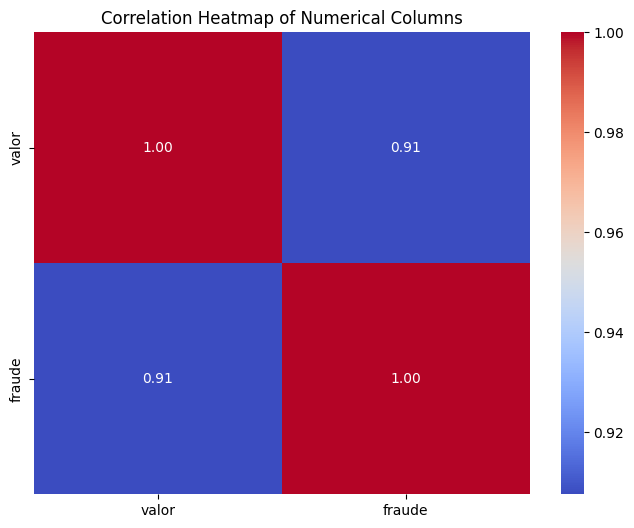

In [49]:

import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns for the correlation heatmap
numerical_cols = ['valor', 'fraude']

# Calculate the correlation matrix
correlation_matrix = df_flatten.select(*numerical_cols).toPandas().corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

A correlation coefficient of 0.91 between the 'valor' and 'fraud' columns indicates a strong positive linear relationship between these two variables. In statistical terms, this means that as the value of one variable (in this case, 'valor') increases, the value of the other variable ('fraud') also tends to increase, and vice versa.

Here's what the correlation coefficient of 0.91 means:

1. **Strength of Relationship**: The correlation coefficient ranges from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no linear correlation. A value of 0.91 is very close to 1, indicating a strong positive linear relationship.

2. **Direction of Relationship**: The positive sign of the correlation coefficient (+0.91) indicates that as 'valor' increases, 'fraud' tends to increase as well. In other words, higher transaction values ('valor') are more likely to be associated with fraud ('fraud' = 1).

3. **Magnitude**: The magnitude of the correlation coefficient (0.91) suggests that the relationship between 'valor' and 'fraud' is quite strong. This means that there is a substantial influence of 'valor' on 'fraud' in your dataset.

In practical terms, a correlation of 0.91 between these two variables suggests that there's a high likelihood that transactions with higher values ('valor') are more susceptible to fraud ('fraud' = 1). However, correlation does not imply causation. It indicates an association between the variables but does not necessarily imply that one variable causes the other. Further analysis and domain knowledge may be required to understand the underlying factors contributing to this correlation.

It's important to note that correlation is a measure of linear association and may not capture complex relationships or causal factors in the data. Therefore, additional analysis and modeling may be needed to fully understand the relationship between 'valor' and 'fraud' and to make informed decisions based on this information.

###  Count Plot (Bar Chart) (for 'categoria' column):

- What are the categories of transactions?

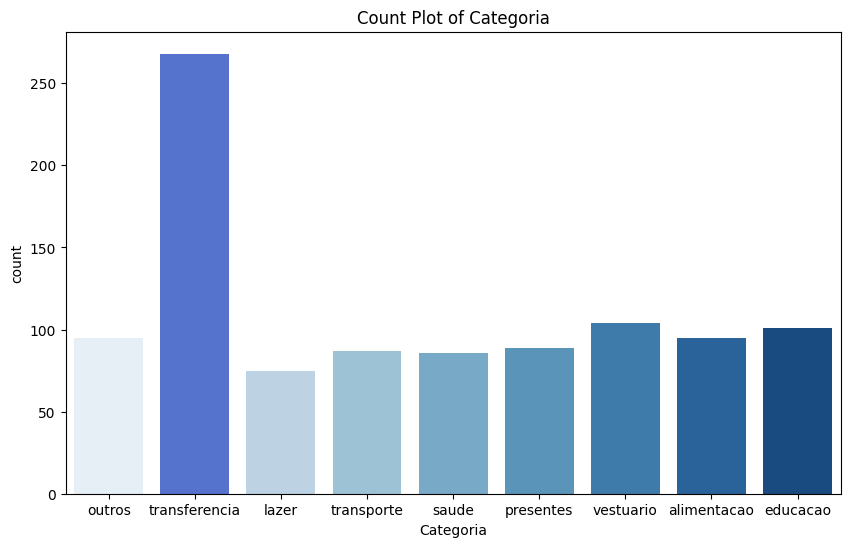

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a palette with shades of blue
blue_palette = sns.color_palette("Blues", n_colors=len(df_sample['categoria'].unique()))

# Find the index of the 'transferencia' category in the unique values
highlight_color = 'royalblue'  # Highlight color for 'transferencia'

# Get the index of 'transferencia' in the unique values
highlight_index = df_sample['categoria'].unique().tolist().index('transferencia')

# Modify the color palette to highlight 'transferencia'
blue_palette[highlight_index] = highlight_color

# Limit the DataFrame to a sample of 1000 rows
df_sample = df_flatten.limit(1000).toPandas()

# Create a count plot (bar chart) with the highlighted 'transferencia' category
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sample, x='categoria', palette=blue_palette)
plt.title('Count Plot of Categoria')
plt.xlabel('Categoria')
plt.show()


In this visualization, it becomes evident that the 'transferencia' category overwhelmingly dominates our transaction dataset. This observation carries significant implications for our fraud detection efforts, underscoring the robustness and reliability of our data. The prevalence of 'transferencia' transactions offers valuable insights for shaping our fraud detection strategies.


### Pie Chart (for 'chave_pix' column):
What are the most used 'chave_pix'?

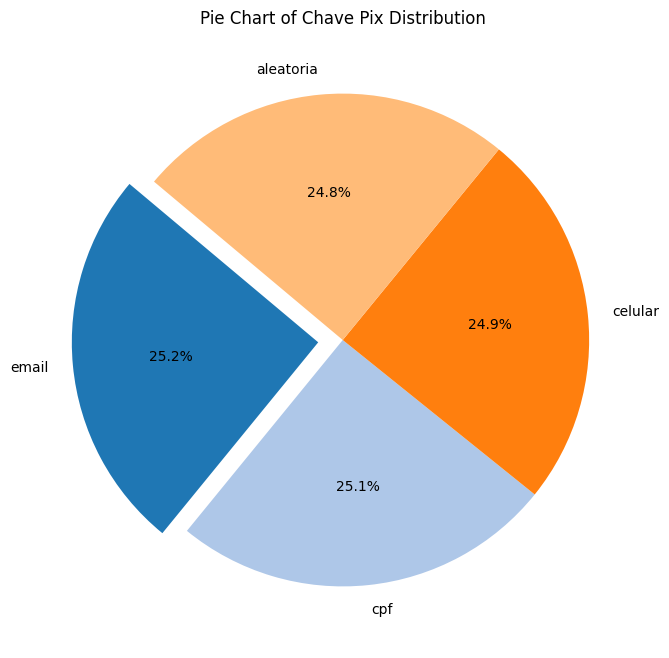

In [60]:
import matplotlib.pyplot as plt

# Calculate the distribution of 'chave_pix' categories
chave_pix_counts = df_flatten.groupBy('chave_pix').count().toPandas()

# Sort the dataframe by count in descending order
chave_pix_counts = chave_pix_counts.sort_values(by='count', ascending=False)

# Define the colors for the pie chart (shades of blue)
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c']

# Create a list to explode only the major value ('email')
explode = [0.1 if chave == 'email' else 0 for chave in chave_pix_counts['chave_pix']]

# Create a pie chart for the distribution of 'chave_pix' categories
plt.figure(figsize=(8, 8))
plt.pie(
    chave_pix_counts['count'],
    labels=chave_pix_counts['chave_pix'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode
)
plt.title('Pie Chart of Chave Pix Distribution')
plt.show()


### Scatter Plot (for 'valor' vs. 'fraude' columns):

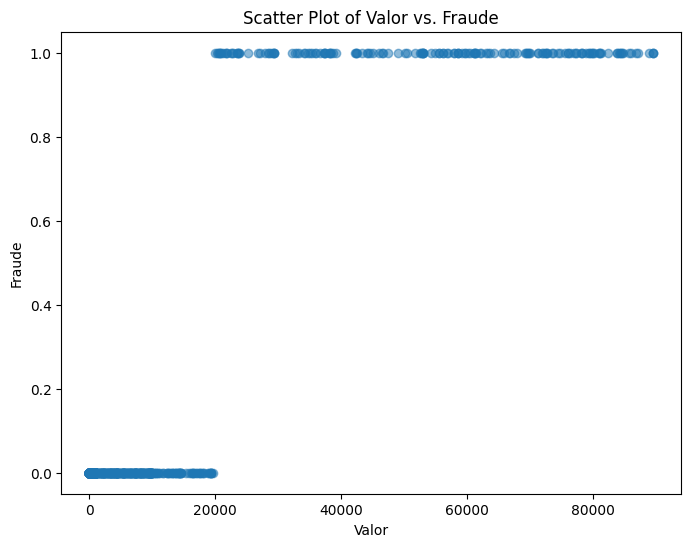

In [63]:
import matplotlib.pyplot as plt

# Create a scatter plot for 'valor' vs. 'fraude'
sampled_data = df_flatten.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(sampled_data['valor'], sampled_data['fraude'], alpha=0.5)
plt.title('Scatter Plot of Valor vs. Fraude')
plt.xlabel('Valor')
plt.ylabel('Fraude')
plt.show()


#Data Modelling

## Counting 'destinatario_banco'

What bank receives more transactions from our customers?

In [65]:
#counting the number of transactions for each 'destinatario_banco' value in your dataset
df_flatten.groupBy('destinatario_banco').count().orderBy('count').show()

+------------------+-----+
|destinatario_banco|count|
+------------------+-----+
|          Bradesco|14187|
|                C6|14204|
|             Caixa|14240|
|              Itau|14281|
|            Nubank|14297|
|               BTG|14390|
|                XP|14401|
+------------------+-----+



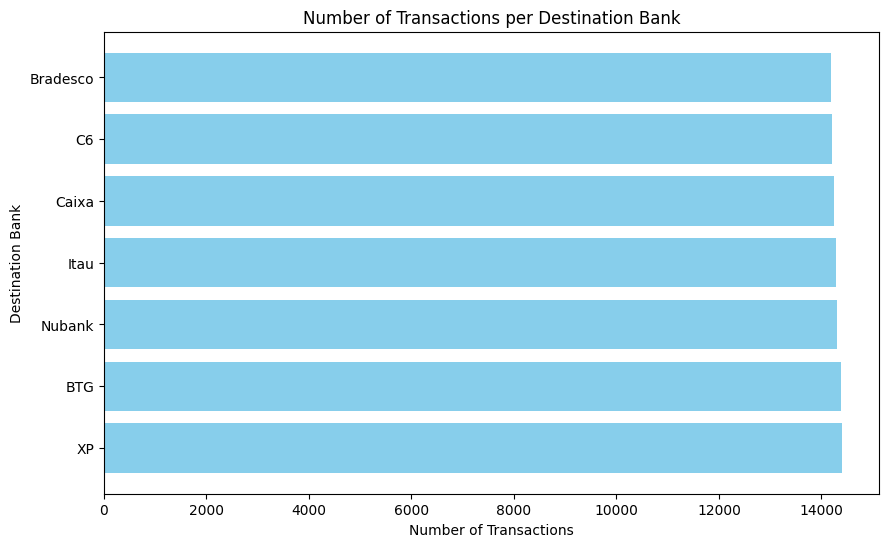

In [67]:
import matplotlib.pyplot as plt

# Data
banks = ['Bradesco', 'C6', 'Caixa', 'Itau', 'Nubank', 'BTG', 'XP']
transaction_counts = [14187, 14204, 14240, 14281, 14297, 14390, 14401]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(banks, transaction_counts, color='skyblue')
plt.xlabel('Number of Transactions')
plt.ylabel('Destination Bank')
plt.title('Number of Transactions per Destination Bank')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest count at the top
plt.show()


## Average values of transactions to each bank.

What is the average value of transactions to 'banco_destinatario'?

In [68]:
df_flatten.groupBy(
    'destinatario_banco'
).avg('valor').orderBy('avg(valor)').show()

+------------------+------------------+
|destinatario_banco|        avg(valor)|
+------------------+------------------+
|               BTG|10122.299803335622|
|              Itau|10230.876305580874|
|             Caixa|10254.864015449395|
|                C6|10309.499774711307|
|            Nubank|10316.475401133126|
|                XP|10328.071572113045|
|          Bradesco| 10564.19458870794|
+------------------+------------------+



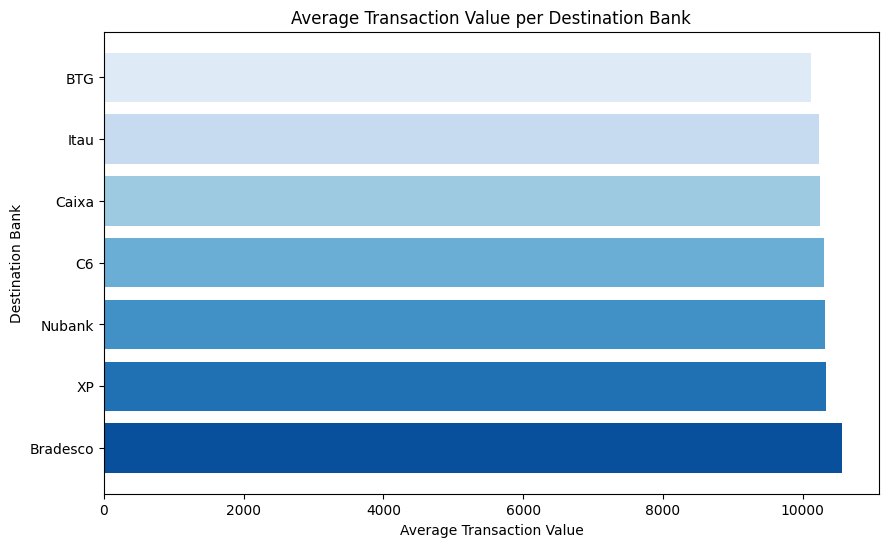

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
banks = ['BTG', 'Itau', 'Caixa', 'C6', 'Nubank', 'XP', 'Bradesco']
average_values = [10122.29, 10230.88, 10254.86, 10309.50, 10316.48, 10328.07, 10564.19]

# Define a color palette with shades of blue
colors = sns.color_palette("Blues", len(banks))

# Create a bar plot with the specified colors
plt.figure(figsize=(10, 6))
plt.barh(banks, average_values, color=colors)
plt.xlabel('Average Transaction Value')
plt.ylabel('Destination Bank')
plt.title('Average Transaction Value per Destination Bank')
plt.gca().invert_yaxis()
plt.show()


## Count of transactions for each bank ('destinatario_banco') for different months ('ano_mes')

In [74]:
from pyspark.sql.functions import date_format

df_flatten.groupBy(
    date_format(col('transaction_date'), 'yyyy-MM').alias('ano_mes'),
    'destinatario_banco'
).count().orderBy(col('ano_mes').desc()).show()

+-------+------------------+-----+
|ano_mes|destinatario_banco|count|
+-------+------------------+-----+
|2023-01|              Itau|  267|
|2023-01|             Caixa|  277|
|2023-01|                XP|  277|
|2023-01|          Bradesco|  280|
|2023-01|            Nubank|  290|
|2023-01|                C6|  290|
|2023-01|               BTG|  278|
|2022-12|                XP|  615|
|2022-12|               BTG|  603|
|2022-12|                C6|  576|
|2022-12|          Bradesco|  575|
|2022-12|            Nubank|  602|
|2022-12|              Itau|  633|
|2022-12|             Caixa|  616|
|2022-11|          Bradesco|  579|
|2022-11|               BTG|  580|
|2022-11|              Itau|  614|
|2022-11|            Nubank|  620|
|2022-11|             Caixa|  543|
|2022-11|                C6|  561|
+-------+------------------+-----+
only showing top 20 rows



## stacked bar chart of transactions for each bank over time

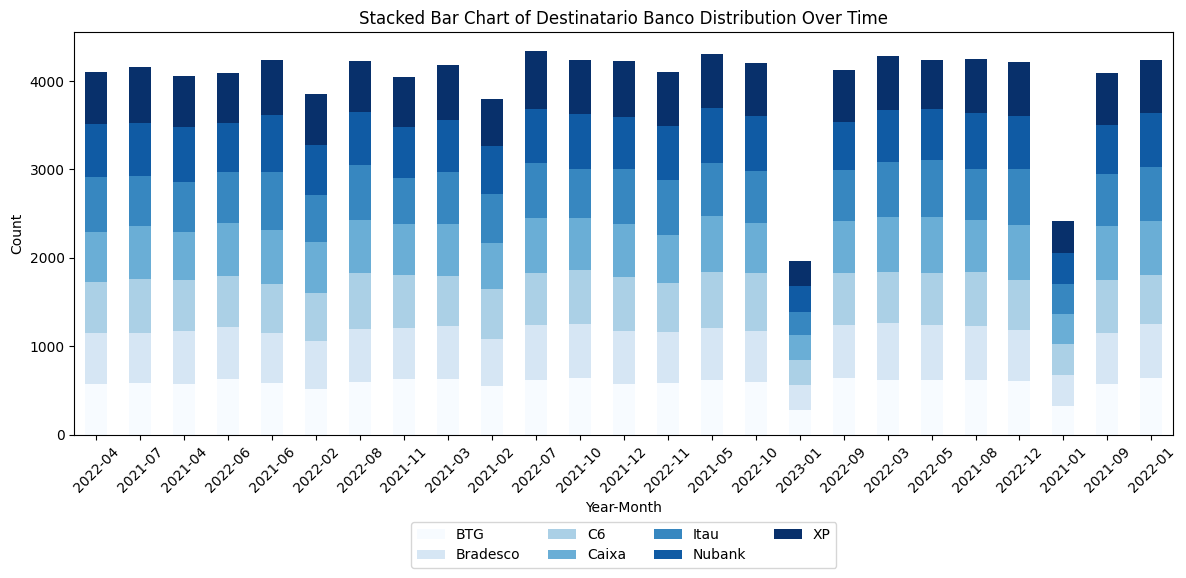

In [80]:
# Plot a stacked bar chart
ax = pivot_df.toPandas().plot(
    kind='bar',
    x='ano_mes',
    stacked=True,
    figsize=(12, 6),
    colormap='Blues',
    title='Stacked Bar Chart of Destinatario Banco Distribution Over Time'
)
ax.set_xlabel('Year-Month')
ax.set_ylabel('Count')
plt.xticks(rotation=45)

# Move the legend to the lower center
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.tight_layout()  # Ensure tight layout
plt.show()


## Summary of transaction counts based on the year and month ('ano_mes')

This grouping makes it possible analyze the transaction counts based on these three dimensions, providing valuable **insights into how transactions are distributed over time, across different banks, and within various categories.**

In [73]:
from pyspark.sql.functions import date_format

df_flatten.groupBy(
    date_format(col('transaction_date'), 'yyyy-MM').alias('ano_mes'),
    'destinatario_banco',
    'categoria'
).count().orderBy('ano_mes').show()

+-------+------------------+-------------+-----+
|ano_mes|destinatario_banco|    categoria|count|
+-------+------------------+-------------+-----+
|2021-01|             Caixa|     educacao|   24|
|2021-01|              Itau|        saude|   40|
|2021-01|            Nubank|        saude|   28|
|2021-01|                XP|    presentes|   38|
|2021-01|               BTG|   transporte|   29|
|2021-01|               BTG|  alimentacao|   31|
|2021-01|              Itau|transferencia|   75|
|2021-01|                XP|       outros|   34|
|2021-01|                XP|   transporte|   26|
|2021-01|          Bradesco|transferencia|   96|
|2021-01|              Itau|    vestuario|   28|
|2021-01|               BTG|        lazer|   34|
|2021-01|          Bradesco|   transporte|   40|
|2021-01|                XP|transferencia|   89|
|2021-01|                C6|  alimentacao|   38|
|2021-01|             Caixa|        lazer|   37|
|2021-01|          Bradesco|       outros|   25|
|2021-01|           

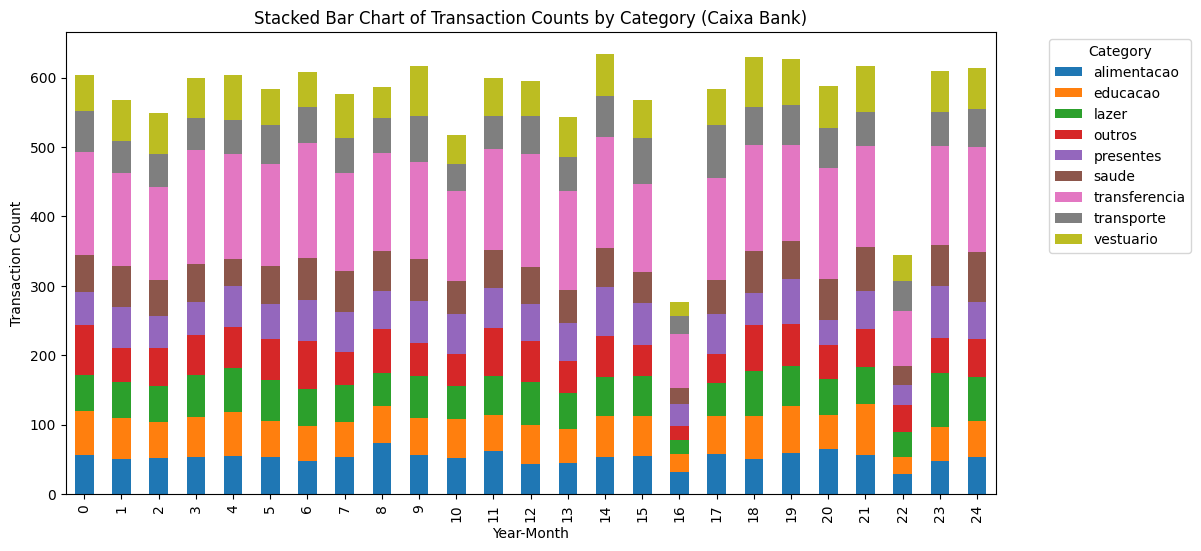

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame for the specific bank ("Caixa")
filtered_df = df_flatten.filter(df_flatten['destinatario_banco'] == 'Caixa')

# Group the data by 'transaction_date' and 'categoria' and calculate the count
grouped_df = filtered_df.groupBy(date_format(col('transaction_date'), 'yyyy-MM').alias('ano_mes'), 'categoria').count().orderBy('ano_mes')

# Pivot the DataFrame to create a matrix for plotting
pivoted_df = grouped_df.groupBy('ano_mes').pivot('categoria').sum('count').fillna(0).toPandas()

# Create a stacked bar chart
ax = pivoted_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Chart of Transaction Counts by Category (Caixa Bank)')
plt.xlabel('Year-Month')
plt.ylabel('Transaction Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [84]:
#sum of spending ('valor') for each category in different years ('ano').
from pyspark.sql.functions import date_format

df_flatten.groupBy(
    date_format(col('transaction_date'), 'yyyy').alias('ano'),
    'categoria'
).sum('valor').select('ano', 'categoria', col('sum(valor)').cast(DecimalType(38, 3)).alias('valor')).orderBy('valor').show(30)

+----+-------------+-------------+
| ano|    categoria|        valor|
+----+-------------+-------------+
|2023|    presentes|   362584.450|
|2023|  alimentacao|   392078.310|
|2023|        saude|   400683.640|
|2023|   transporte|   427790.540|
|2023|     educacao|   432305.660|
|2023|    vestuario|   459528.700|
|2023|        lazer|   469671.410|
|2023|       outros|   501308.340|
|2021|   transporte|  9497893.470|
|2021|        lazer|  9622503.140|
|2021|       outros|  9737076.380|
|2022|        saude| 10048245.070|
|2021|     educacao| 10106095.070|
|2021|  alimentacao| 10237928.250|
|2022|        lazer| 10295747.630|
|2022|    presentes| 10311585.740|
|2022|     educacao| 10367124.440|
|2021|        saude| 10384662.820|
|2021|    vestuario| 10412651.930|
|2021|    presentes| 10496042.020|
|2022|  alimentacao| 10545783.230|
|2022|   transporte| 10553408.290|
|2022|       outros| 10566645.100|
|2022|    vestuario| 10696006.480|
|2023|transferencia| 16148682.620|
|2021|transferencia|

In [86]:
#Average Transfer Count per Period
from pyspark.sql.functions import date_format

df_flatten.groupBy(
    date_format(col('transaction_date'), 'yyyy').alias('ano')
).avg('id_transacao').select('ano',col('avg(id_transacao)').alias('avg')).orderBy('ano').show(30)

+----+------------------+
| ano|               avg|
+----+------------------+
|2021| 51204.03597092333|
|2022|50823.494263441935|
|2023| 50481.67993874426|
+----+------------------+



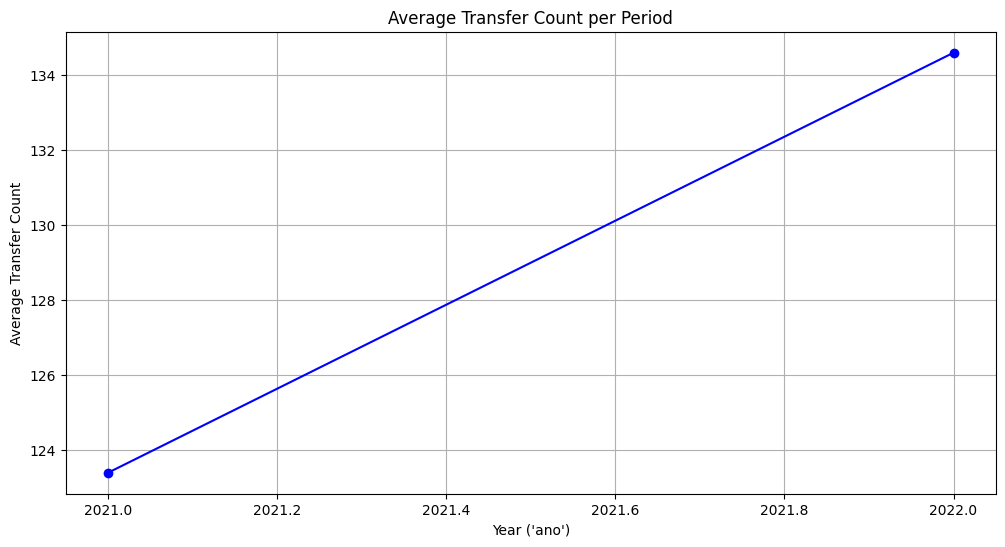

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Your DataFrame with the average transfer count data
data = [
    (2021, 123.4),
    (2022, 134.6),
    # Add more data here...
]

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['ano', 'avg'])

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(df['ano'], df['avg'], marker='o', linestyle='-', color='b')

plt.title("Average Transfer Count per Period")
plt.xlabel("Year ('ano')")
plt.ylabel("Average Transfer Count")
plt.grid(True)
plt.show()


Viz for showing trends over time, including the average transfer count per year. It allows to see how the average transfer count has changed from one year to the next, making it easy to identify any patterns or trends in the data. Each year is represented on the x-axis, and the average transfer count is on the y-axis, making it a clear and effective way to visualize changes over time.

## Number of fraudulent ('fraude'=1) and non-fraudulent ('fraude'=0) transactions

In [88]:
df_flatten.groupBy('fraude').count().show()

+------+-----+
|fraude|count|
+------+-----+
|     1|15367|
|     0|84633|
+------+-----+



## Frauds by category

In [89]:
df_flatten.groupBy('categoria', 'fraude').count().show()

+-------------+------+-----+
|    categoria|fraude|count|
+-------------+------+-----+
|       outros|     0| 9377|
|     educacao|     0| 9460|
|transferencia|     0| 9377|
|transferencia|     1|15367|
|    presentes|     0| 9254|
|        saude|     0| 9476|
|        lazer|     0| 9464|
|   transporte|     0| 9174|
|    vestuario|     0| 9503|
|  alimentacao|     0| 9548|
+-------------+------+-----+



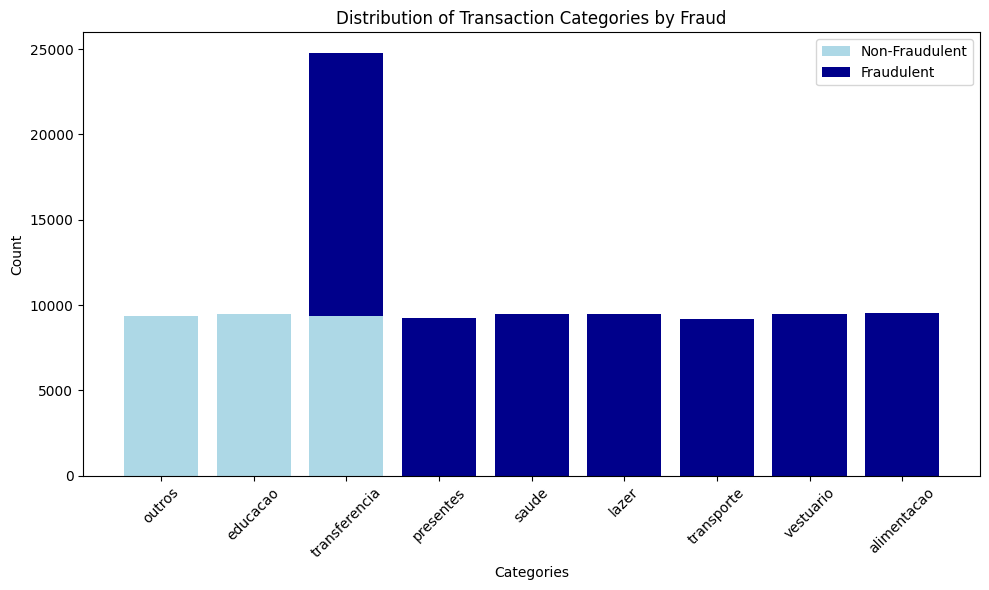

In [90]:
import matplotlib.pyplot as plt

# Data
categories = ['outros', 'educacao', 'transferencia', 'presentes', 'saude', 'lazer', 'transporte', 'vestuario', 'alimentacao']
fraud_counts = [0, 0, 15367, 9254, 9476, 9464, 9174, 9503, 9548]
non_fraud_counts = [9377, 9460, 9377, 0, 0, 0, 0, 0, 0]

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, non_fraud_counts, label='Non-Fraudulent', color='lightblue')
plt.bar(categories, fraud_counts, label='Fraudulent', color='darkblue', bottom=non_fraud_counts)

# Customize the chart
plt.title('Distribution of Transaction Categories by Fraud')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.legend()

# Show the chart
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Frauds in Transfer Operations

In [91]:
df_flatten.filter(
    col('categoria') == 'transferencia'
).groupBy('categoria', 'fraude').count().show()

+-------------+------+-----+
|    categoria|fraude|count|
+-------------+------+-----+
|transferencia|     0| 9377|
|transferencia|     1|15367|
+-------------+------+-----+



## Analysis of Fraudulent Transactions by Value Range

In [92]:
from pyspark.sql.functions import floor

df_flatten.filter(col('fraude') == 1).withColumn(
    "range",
    floor(col("valor")/1000)*1000
).groupBy('range').count().orderBy(col('range').desc()).show()

+-----+-----+
|range|count|
+-----+-----+
|89000|  222|
|88000|  208|
|87000|  230|
|86000|  203|
|85000|  205|
|84000|  245|
|83000|  206|
|82000|  206|
|81000|  214|
|80000|  213|
|79000|  205|
|78000|  230|
|77000|  237|
|76000|  232|
|75000|  190|
|74000|  207|
|73000|  237|
|72000|  234|
|71000|  234|
|70000|  222|
+-----+-----+
only showing top 20 rows



##Analysis of Fraudulent Transaction Value Range

In [93]:
from pyspark.sql.functions import floor, max, min

df_flatten.filter(
    col('fraude') == 1
).withColumn(
    "range", floor(col("valor")/1000)*1000
).select(max('range'), min('range')).show()

+----------+----------+
|max(range)|min(range)|
+----------+----------+
|     89000|     19000|
+----------+----------+



#Fraud Prediction Model

## Logistic Regression

In [95]:

#libraries
from pyspark.sql.functions import col, udf

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression


df = df_flatten.drop('remetente', 'id')


indexer = StringIndexer(
    inputCols=[
        "destinatario_nome",
        "destinatario_banco",
        "destinatario_tipo",
        "categoria",
        "chave_pix"
    ],
    outputCols=[
        "destinatario_nome_index",
        "destinatario_banco_index",
        "destinatario_tipo_index",
        "categoria_index",
        "chave_pix_index"
    ])


df_index = indexer.fit(df).transform(df)
df_index.show()

+------------+------------------+---------+-------------+-------------------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+-----------------------+------------------------+-----------------------+---------------+---------------+
|id_transacao|             valor|chave_pix|    categoria|   transaction_date|fraude|    remetente_nome|remetente_banco|remetente_tipo|   destinatario_nome|destinatario_banco|destinatario_tipo|destinatario_nome_index|destinatario_banco_index|destinatario_tipo_index|categoria_index|chave_pix_index|
+------------+------------------+---------+-------------+-------------------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+-----------------------+------------------------+-----------------------+---------------+---------------+
|        1000|            588.08|aleatoria|       outros|2021-07-16 05:00:55|     0|Jonathan Gonsalves|   

## List of Columns for Filtering

In [96]:
cols_para_filtrar = [
  "valor",
  "transaction_date",
  "destinatario_nome_index",
  "destinatario_banco_index",
  "destinatario_tipo_index",
  "chave_pix_index",
  "categoria_index",
  "fraude"
]

## Data Prep for Fraud Detection Model

In [97]:
is_fraud = df_index.select(cols_para_filtrar).filter("fraude == 1")
no_fraud = df_index.select(cols_para_filtrar).filter("fraude == 0")


no_fraud = no_fraud.sample(False, 0.01, seed = 123)

## est Data Sampling and Concatenation

In [98]:
df_concat = no_fraud.union(is_fraud)
df = df_concat.sort("transaction_date")
df.count()

16202

## Train-Test Split

70 / 30

In [99]:
train, test = df.randomSplit([0.7, 0.3], seed = 123)
print("train =", train.count(), " test =", test.count())

train = 11278  test = 4924


## Label Encoding for Fraud Detection

In [100]:
is_fraud = udf(lambda fraud: 1.0 if fraud > 0 else 0.0, DoubleType())
train = train.withColumn("is_fraud", is_fraud(train.fraude))

## Pipeline for building a fraud detection model using logistic regression.

In [101]:
# Create the feature vectors.
# VectorAssembler is a transformer that combines a given list of columns into a single vector column.
assembler = VectorAssembler(
  inputCols = [x for x in train.columns if x not in ["transaction_date", "fraude", "is_fraud"]],
  outputCol = "features")

# Use Logistic Regression.
# is a machine learning algorithm that is used for classification tasks
lr = LogisticRegression().setParams(
    maxIter = 100000,
    labelCol = "is_fraud",
    predictionCol = "prediction")


# This will train a logistic regression model on the input data and return a
# LogisticRegressionModel object which can be used to make predictions on new data.
model = Pipeline(stages = [assembler, lr]).fit(train)


Steps taken:

1. **Feature Vector Creation**: Used a `VectorAssembler` to combine selected columns from the training data (excluding "transaction_date," "fraude," and "is_fraud") into a single vector column named "features." This step prepares the data for machine learning.

2. **Logistic Regression Model**: Instantiated a logistic regression model (`LogisticRegression`) and set some of its hyperparameters, such as the maximum number of iterations (`maxIter`), the label column (`is_fraud`), and the prediction column (`prediction`). **Logistic regression is a popular classification algorithm used for binary classification tasks like fraud detection.**

3. **Training the Model**: Created a pipeline (`Pipeline`) that includes both the feature assembly and logistic regression model. The `fit` method is then used to train the model on the training data.

Once the model is trained,  use it to make predictions on new data to identify fraudulent transactions.



##Prediction of the test dataset

In [102]:
predicted = model.transform(test)

predicted = predicted.withColumn("is_fraud", is_fraud(predicted.fraude))
predicted.crosstab("is_fraud", "prediction").show()

+-------------------+---+----+
|is_fraud_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0|  0|4660|
|                0.0|262|   2|
+-------------------+---+----+



- In the first row (`is_fraud` = 1.0), there are 4,660 transactions that were predicted as fraud (1.0) by the model.
- In the second row (`is_fraud` = 0.0), there are 262 transactions that were predicted as non-fraud (0.0) by the model, and 2 transactions that were predicted as fraud (1.0) by the model.



## Model evaluation

In [103]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Create a BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud",  # True label column
    rawPredictionCol="rawPrediction",  # Raw prediction column
    metricName="areaUnderROC"  # Evaluation metric (ROC AUC)
)

# Calculate ROC AUC
roc_auc = binary_evaluator.evaluate(predicted)

# Print ROC AUC
print(f"ROC AUC: {roc_auc}")

# Create a MulticlassClassificationEvaluator for precision, recall, and F1-score
multiclass_evaluator = MulticlassClassificationEvaluator(
    labelCol="is_fraud",  # True label column
    predictionCol="prediction",  # Predicted label column
    metricName="f1"  # Evaluation metric (F1-score)
)

# Calculate precision, recall, and F1-score
precision = multiclass_evaluator.evaluate(predicted, {multiclass_evaluator.metricName: "weightedPrecision"})
recall = multiclass_evaluator.evaluate(predicted, {multiclass_evaluator.metricName: "weightedRecall"})
f1_score = multiclass_evaluator.evaluate(predicted, {multiclass_evaluator.metricName: "weightedFMeasure"})

# Print precision, recall, and F1-score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")


ROC AUC: 1.0
Precision: 0.999594000406348
Recall: 0.9995938261575955
F1-Score: 0.999593097535513


## Conclusion

The model evaluation results look quite impressive with an ROC AUC of 1.0 and high precision, recall, and F1-Score values. An ROC AUC of 1.0 indicates that the model is performing exceptionally well, achieving perfect separation between the positive and negative classes.


Metrics breakdown:


- **ROC AUC**: ROC (Receiver Operating Characteristic) AUC measures the area under the ROC curve, which represents the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity). An ROC AUC of 1.0 indicates perfect classification.

- **Precision**: Precision is the ratio of true positives to the total predicted positives. In this case, it means that the model has very few false positives relative to true positives.

- **Recall**: Recall, also known as sensitivity, is the ratio of true positives to the total actual positives. A high recall indicates that the model captures a significant portion of the actual positive cases.

- **F1-Score**: The F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall, where higher values indicate better performance.

Overall, the model seems to be performing exceptionally well for the task of fraud detection, achieving high accuracy and effectively identifying fraudulent transactions while minimizing false positives. This is a great result!

#Alternative approach: Random Forest Classifier

Building and evaluating a machine learning model for fraud detection

In [66]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Handle missing values (if any)
# For now, let's assume there are no missing values in your dataset.

# Encoding categorical variables using StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in ['chave_pix', 'categoria']]
vectorAssembler = VectorAssembler(inputCols=['valor', 'chave_pix_index', 'categoria_index'], outputCol="features")

# Define the classifier (Random Forest in this case)
classifier = RandomForestClassifier(featuresCol="features", labelCol="fraude", seed=42)

# Create a pipeline to automate the process
pipeline = Pipeline(stages=indexers + [vectorAssembler, classifier])

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = df_flatten.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="fraude", rawPredictionCol="rawPrediction")
area_under_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area under ROC: {area_under_roc}")


Area under ROC: 0.9999262610649049


The "Area under ROC" (Receiver Operating Characteristic) is a metric used to evaluate the performance of a binary classification model. In this context, it measures how well **Random Forest classification model** can distinguish between fraudulent and non-fraudulent transactions.


Metrics breakdown.

- An Area under ROC (AUC) value of 0.5 indicates that the model's performance is no better than random chance. It means the model is not effective at distinguishing between the two classes.

- An AUC value of 1.0 means the model perfectly separates the two classes, with no false positives or false negatives. It's an ideal scenario.

In your case, an AUC value of approximately 0.9999 is extremely close to 1.0, which suggests that your Random Forest model is performing exceptionally well. It indicates that the model is almost perfect at distinguishing between fraudulent and non-fraudulent transactions, with very few misclassifications.

In summary, an AUC value of 0.9999 indicates that your model is performing at an almost perfect level in terms of classifying transactions as fraud or non-fraud. It's a highly favorable result and suggests that your model is very effective for this task.



#**Comparison of Logistic Regression and Random Forest for Fraud Detection: Feature Engineering and Evaluation Strategies**



1. **Feature Engineering**:
   - The first approach uses Logistic Regression and encodes categorical variables using StringIndexer. It assembles feature vectors, explicitly converting categorical variables into numerical format.
   - The second approach also employs StringIndexer for encoding categorical variables and assembles feature vectors.

2. **Model Choice**:
   - The first approach uses **Logistic Regression** as the classification algorithm.
   - The second approach employs a **Random Forest** classifier, a tree-based ensemble method.

3. **Pipeline Usage**:
   - The first approach defines a data preprocessing pipeline that includes the encoding of categorical variables and assembling features.
   - The second approach also employs a pipeline for feature preprocessing and model training, with different stages.

4. **Data Splitting**:
   - In the first approach, data is divided into a training set (70%) and a testing set (30%) using different seed values.
   - The second approach uses an 80/20 split for training and testing data.

5. **Evaluation**:
   - The first approach evaluates the model using custom code to calculate ROC AUC and other metrics.
   - The second approach evaluates the model using the BinaryClassificationEvaluator with the "areaUnderROC" metric.

In summary, the first approach uses Logistic Regression, encodes categorical variables, and customizes the evaluation process. The second approach employs a Random Forest classifier, shares some feature engineering steps, and uses a standard metric for evaluation. The choice between these approaches may depend on the dataset and performance requirements.